#🧪 Risk Stratification for Type 2 Diabetes (Hands-on)

Prepared by: Kezia Irene (@kezia_tesiman)

Welcome to the Risk Stratification Workshop!
In this lab, we’ll use Vertex AI and PRSedm to run a partitioned polygenic risk score (PRS) pipeline for Type 2 Diabetes (T2D).

We’ll:

1. Spin up a Docker image that can run PRSedm in the cloud

2. Use Vertex AI CustomJob to score a VCF file stored in Cloud Storage

3. Get a CSV of PRS outputs that you can explore or visualize

We’ll use the PRSedm pipeline from:
👉 https://github.com/sethsh7/PRSedm

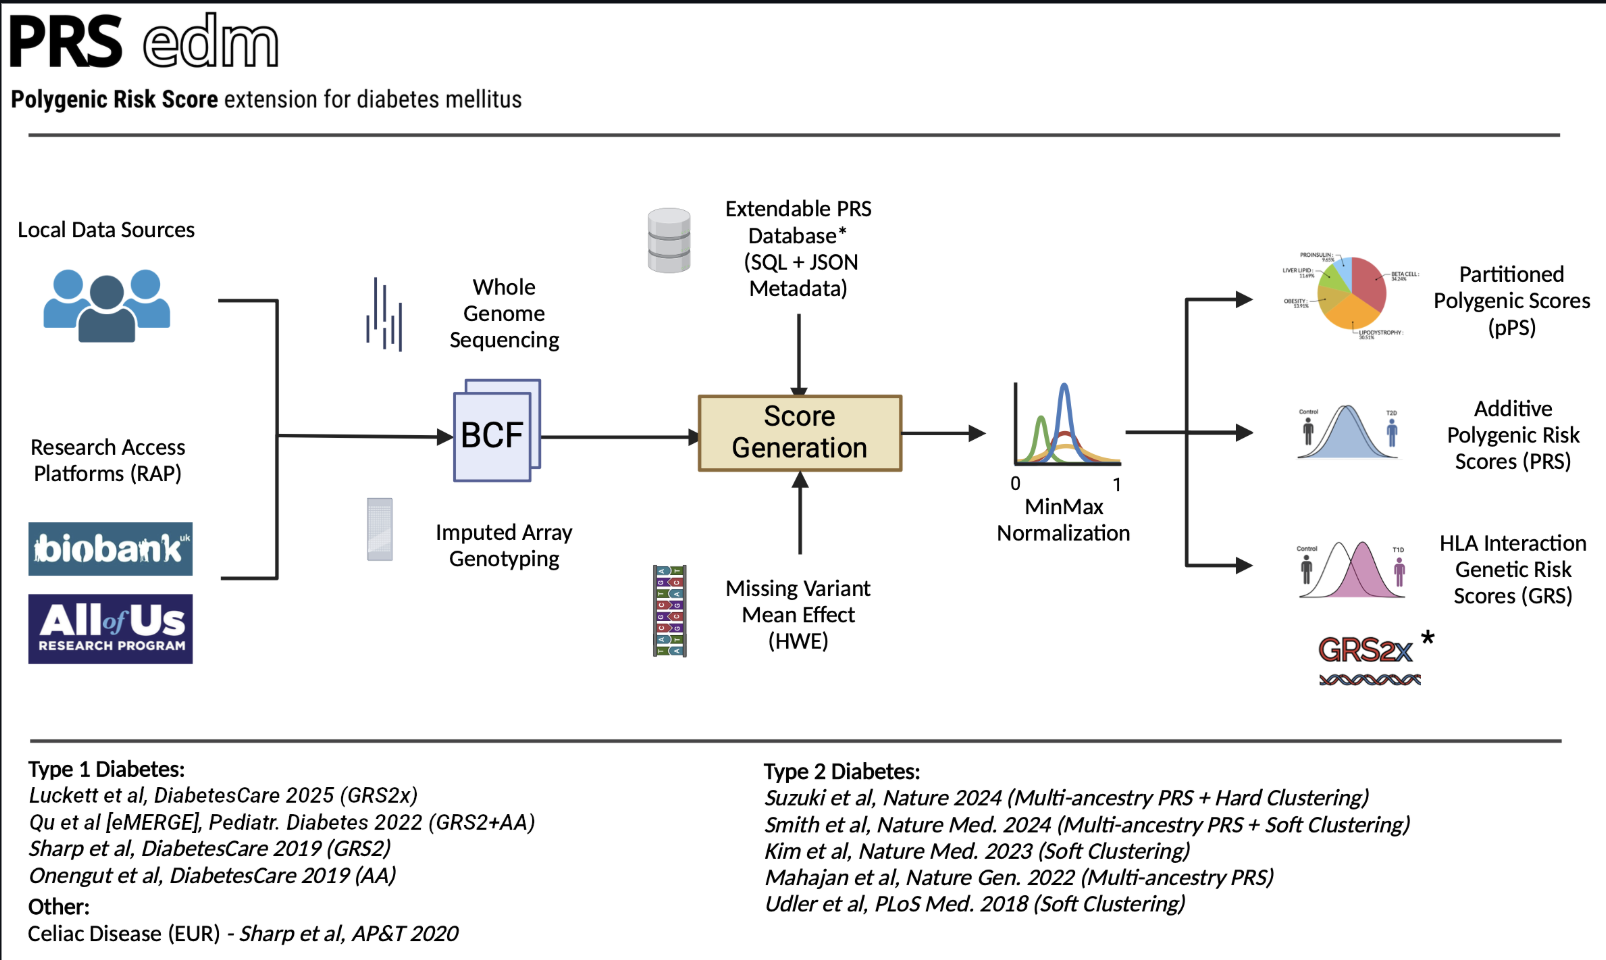

## What is a Polygenic Risk Score (PRS)?

Most common diseases (like Type 2 Diabetes) are not driven by a single “bad gene”, but by **thousands of variants**, each contributing a tiny amount to risk.

A **polygenic risk score (PRS)** is a way to **summarize all those tiny effects into one number**:

\[
\text{PRS} = \sum_{\text{variants}} (\text{effect size}_i \times \text{genotype}_i)
\]

- Each variant has an **effect size** (from GWAS).  
- Each person has a **genotype** at that variant (e.g., 0, 1, or 2 risk alleles).  
- PRS adds them up into **one score per person**.

A higher PRS means **higher genetic predisposition** to that trait compared to others in the population.

---

## What is a *partitioned* PRS?

A single PRS score tells us **“how high”** someone’s genetic risk is — but not **“why”**.

A **partitioned PRS** splits the total score into **biological pathways or clusters**, for example in T2D:

- **Betacell+PI** – pancreatic insulin secretion  
- **Bodyfat / Obesity** – adiposity and fat distribution  
- **Liver / lipid metabolism** – liver fat and lipid handling  
- **Metabolic syndrome** – blood pressure, triglycerides, HDL, etc.  
- **Residual glycaemic** – glycaemic risk not explained by the other clusters

So for each person, instead of just:

> “Your T2D PRS is high.”

we get something richer:

> “Your T2D risk is high, *mainly* because of **obesity and liver metabolism**, not because of beta-cell failure.”

This is what makes partitioned PRS useful for:
- **Understanding mechanism**, not just risk  
- **Personalized interventions** (e.g., lifestyle-focused vs pancreas-focused)  
- Explaining why people like **Anto** and **Budi** can share the same diagnosis, but have **completely different genetic pathways** behind it.


# 0. Set up: Cloud Shell + sample data

Open Google Cloud Console:
https://console.cloud.google.com/

Open Cloud Shell (the little terminal icon in the top-right).

(Optional) If you want to use a real VCF instead of the tiny demo VCF, you can download ClinVar VCFs (GRCh38) from NCBI:

👉 https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/

Example command in Cloud Shell:

You can download the data here: https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/

File to download:
1. clinvar_papu.vcf.gz              2025-11-17 00:58   68K  
2. clinvar_papu.vcf.gz.md5          2025-11-17 00:58  137   
3. clinvar_papu.vcf.gz.tbi          2025-11-17 00:58  783   



Put the file on Google cloud storage: https://console.cloud.google.com/storage

In [ ]:
wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar_papu.vcf.gz


For the workshop, we’ll assume you already have a small VCF and its index in a bucket, e.g.:

In [ ]:
gs://sample_vcf1/input/t2dp_suzuki_synthetic.vcf.gz
gs://sample_vcf1/input/t2dp_suzuki_synthetic.vcf.gz.tbi


# 1. Create a Dockerfile (PRSedm runner image)

In Cloud Shell:

In [ ]:
mkdir -p ~/prsedm-demo
cd ~/prsedm-demo
nano Dockerfile

In [ ]:
# Dockerfile

# Dockerfile - PRSedm runner (minimal)
FROM python:3.10-slim

# system deps for pysam/bgzip/tabix etc
RUN apt-get update && \
    apt-get install -y build-essential gcc libbz2-dev liblzma-dev zlib1g-dev && \
    rm -rf /var/lib/apt/lists/*

WORKDIR /app

# Install PRSedm + GCS client
RUN pip install --no-cache-dir prsedm google-cloud-storage

# copy runner script
COPY runner.py /app/runner.py
RUN mkdir -p /data /output

ENTRYPOINT ["python","/app/runner.py"]

# 2. Create runner.py (container entrypoint)

This script:

Downloads the VCF (and its .tbi index) from GCS

Runs prsedm with the requested score

Uploads the results CSV back to GCS

In Cloud Shell:

In [ ]:
# runner.py (patched to download .tbi index and optional ref index)
import argparse, subprocess, os, sys
from google.cloud import storage

parser = argparse.ArgumentParser()
parser.add_argument("--gcs_vcf", required=True, help="gs://.../file.vcf.gz")
parser.add_argument("--gcs_out", required=True, help="gs://.../out.csv")
parser.add_argument("--scores", required=True, help="comma-separated PRS flags")
# optional passthroughs
parser.add_argument("--col", default="GT", help="genotype column (GT or GP)")
parser.add_argument("--impute", action="store_true", help="enable imputation (requires --refvcf)")
parser.add_argument("--refvcf", default=None, help="gs://.../ref.vcf.gz")
parser.add_argument("--parallel", action="store_true", help="enable parallel")
parser.add_argument("--ntasks", type=int, default=None, help="ntasks for parallel")
parser.add_argument("--batch_size", type=int, default=None, help="variant batch size")
parser.add_argument("--norm", action="store_true", help="perform MinMax normalization")
args = parser.parse_args()

LOCAL_VCF = "/data/input.vcf.gz"
LOCAL_OUT = "/output/results.csv"
LOCAL_REF = "/data/ref.vcf.gz"

def download_from_gcs(gcs_path, local_path):
    client = storage.Client()
    bucket_name = gcs_path.split('/')[2]
    blob_path = '/'.join(gcs_path.split('/')[3:])
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_path)
    print(f"[runner] Downloading {gcs_path} -> {local_path}")
    blob.download_to_filename(local_path)

def upload_to_gcs(local_path, gcs_path):
    client = storage.Client()
    bucket_name = gcs_path.split('/')[2]
    blob_path = '/'.join(gcs_path.split('/')[3:])
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_path)
    print(f"[runner] Uploading {local_path} -> {gcs_path}")
    blob.upload_from_filename(local_path)

def try_download_index(gcs_vcf_path, local_vcf_path):
    # try to download .tbi index adjacent to the vcf path
    idx_gcs = gcs_vcf_path + ".tbi"
    local_idx = local_vcf_path + ".tbi"
    try:
        download_from_gcs(idx_gcs, local_idx)
        print(f"[runner] Downloaded index: {idx_gcs}")
    except Exception as e:
        print(f"[runner] WARNING: failed to download index {idx_gcs}: {e}")

def run_prsedm(vcf_local, out_local):
    cmd = ["prsedm","--vcf", vcf_local, "--scores", args.scores, "--output", out_local, "--col", args.col]
    if args.impute:
        cmd += ["--impute"]
        if args.refvcf:
            cmd += ["--refvcf", LOCAL_REF]
    if args.parallel:
        cmd += ["--parallel"]
    if args.ntasks:
        cmd += ["--ntasks", str(args.ntasks)]
    if args.batch_size:
        cmd += ["--batch-size", str(args.batch_size)]
    if args.norm:
        cmd += ["--norm"]
    print("[runner] Running command:", " ".join(cmd))
    subprocess.check_call(cmd)

if __name__ == "__main__":
    # download vcf
    download_from_gcs(args.gcs_vcf, LOCAL_VCF)

    # attempt to download .tbi index next to the VCF
    try_download_index(args.gcs_vcf, LOCAL_VCF)

    # optional ref vcf + index
    if args.refvcf:
        download_from_gcs(args.refvcf, LOCAL_REF)
        try:
            download_from_gcs(args.refvcf + ".tbi", LOCAL_REF + ".tbi")
            print("[runner] Ref index downloaded.")
        except Exception as e:
            print("[runner] WARNING: ref index download failed:", e)

    # final run
    try:
        run_prsedm(LOCAL_VCF, LOCAL_OUT)
    except subprocess.CalledProcessError as e:
        print("[runner] ERROR: prsedm failed with exit code", e.returncode, file=sys.stderr)
        raise
    upload_to_gcs(LOCAL_OUT, args.gcs_out)
    print("[runner] Done.")


# 3. Build and push the Docker image

In Cloud Shell:

In [ ]:
cd ~/prsedm-demo

export PROJECT_ID="melodic-agent-478708-d2"
export REGION="us-central1"
export REPO="prs-demo-repo"
export IMAGE_NAME="prsedm"
export IMAGE_TAG="v2"
export IMAGE_URI="${REGION}-docker.pkg.dev/${PROJECT_ID}/${REPO}/${IMAGE_NAME}:${IMAGE_TAG}"

gcloud config set project $PROJECT_ID
gcloud config set compute/region $REGION

# Build and push the container
gcloud builds submit --tag $IMAGE_URI .


After it finishes, you’ll have:

In [ ]:
us-central1-docker.pkg.dev/melodic-agent-478708-d2/prs-demo-repo/prsedm:v2


# 4. Create submit_prsedm_job.py (run PRSedm via Vertex AI)

This script:

Tells Vertex AI which image to run

Points to your input VCF in GCS

Writes a CSV of PRS scores back to GCS

👉 For the workshop, we’ll keep it simple: imputation OFF, so we don’t need REF_VCF_PATH.

In [ ]:
from google.cloud import aiplatform

# ==== CONFIGURABLE SETTINGS ====

PROJECT_ID = "melodic-agent-478708-d2"
REGION = "us-central1"
STAGING_BUCKET = f"gs://{PROJECT_ID}-vertex-staging"

IMAGE_URI = "us-central1-docker.pkg.dev/melodic-agent-478708-d2/prs-demo-repo/prsedm:v2"

# ---- VCF in GCS ----
VCF_PATH = "gs://sample_vcf1/input/t2dp_suzuki_synthetic.vcf.gz"

# ---- Output PRS file ----
OUTPUT_PATH = "gs://sample_vcf1/prsedm_output/synthetic_results.csv"

# ---- PRSedm score flag (partitioned T2D PRS) ----
PRS_SCORE = "t2dp-suzuki24-ma"

# ---- Performance / parallelism (optional) ----
PARALLEL = True        # set True to enable --parallel
NTASKS = 4             # number of tasks for PRSedm --ntasks
MACHINE_TYPE = "n1-standard-8"

# ====================================

def build_args():
    args = [
        "--gcs_vcf", VCF_PATH,
        "--gcs_out", OUTPUT_PATH,
        "--scores", PRS_SCORE,
        "--col", "GT",      # use GT for called genotypes
    ]
    if PARALLEL:
        args.append("--parallel")
    if NTASKS:
        args += ["--ntasks", str(NTASKS)]
    return args

def main():
    print("Initializing Vertex AI…")
    aiplatform.init(
        project=PROJECT_ID,
        location=REGION,
        staging_bucket=STAGING_BUCKET
    )

    container_spec = {
        "image_uri": IMAGE_URI,
        "args": build_args()
    }

    worker_pool_specs = [
        {
            "machine_spec": {"machine_type": MACHINE_TYPE},
            "replica_count": 1,
            "container_spec": container_spec
        }
    ]

    job = aiplatform.CustomJob(
        display_name="prsedm-synthetic-demo",
        worker_pool_specs=worker_pool_specs
    )

    print("Submitting PRSedm job to Vertex AI…")
    job.run(sync=True)

    print("\n🎉 Job completed.")
    print("Check results at:", OUTPUT_PATH)

if __name__ == "__main__":
    main()



💡 If later you want to demo imputation, you can add back:

a REF_VCF_PATH = "gs://.../ref.vcf.gz" at the top

--impute and --refvcf, once you have a reference VCF + .tbi in GCS.



# 5. Run everything from Cloud Shell

In [ ]:
python submit_prsedm_job.py


Vertex AI will:

- Start a custom job with your prsedm:v2 image

- Download the VCF from GCS

- Run PRSedm with t2dp-suzuki24-ma

- Upload results to:

In [ ]:
gs://sample_vcf1/prsedm_output/synthetic_results.csv


# Bonus codes:
This code assumes:

You have a PRSedm output CSV, e.g. synthetic_results.csv

It has one row per person, with columns:

- IID
- Betacell+PI
- Betacell-PI
- Bodyfat
- Lipodystrophy
- Liver/lipidmetabolism
- Metabolicsyndrome
- Obesity
- Residualglycaemic
- t2dp-suzuki24-ma_total


In [ ]:
import pandas as pd

# If file is in GCS, first copy it locally in a terminal:
# gsutil cp gs://sample_vcf1/prsedm_output/synthetic_results.csv .

df = pd.read_csv("prsedm_output_synthetic_results1.csv")
df.head()


,IID,Betacell+PI,Betacell-PI,Bodyfat,Lipodystrophy,Liver/lipidmetabolism,Metabolicsyndrome,Obesity,Residualglycaemic,t2dp-suzuki24-ma_total
0,SAMPLE_001,0.45,0.12,0.08,-0.03,0.22,0.10,0.05,-0.02,0.97
1,SAMPLE_002,-0.20,0.05,0.30,0.02,-0.10,0.18,0.12,0.04,0.41
2,SAMPLE_003,1.10,0.35,0.25,0.05,0.40,0.20,0.30,0.10,2.75
3,SAMPLE_004,-0.50,-0.10,0.05,-0.08,-0.12,-0.05,-0.02,0.01,-0.81
4,SAMPLE_005,0.80,0.28,0.15,0.00,0.18,0.12,0.09,0.03,1.65


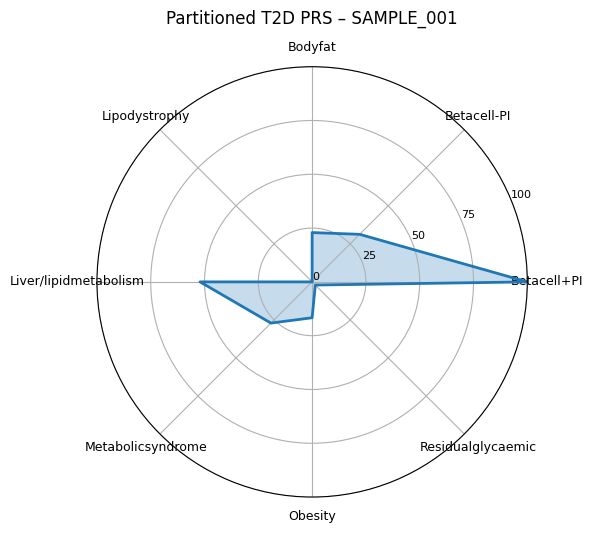

In [ ]:
import matplotlib.pyplot as plt
from math import pi
import numpy as np

# Choose one person (by IID or just take the first row)
iid = df["IID"].iloc[0]
row = df[df["IID"] == iid].iloc[0]

# Partition columns (adjust if your column names differ)
partitions = [
    "Betacell+PI",
    "Betacell-PI",
    "Bodyfat",
    "Lipodystrophy",
    "Liver/lipidmetabolism",
    "Metabolicsyndrome",
    "Obesity",
    "Residualglycaemic",
]

values = np.array([row[p] for p in partitions], dtype=float)

# Optional: normalize to 0–100 for nicer visualization
min_scale, max_scale = values.min(), values.max()
if max_scale == min_scale:
    vals_norm = np.zeros_like(values)
else:
    vals_norm = (values - min_scale) / (max_scale - min_scale) * 100

# Prepare data for radar chart (close the loop)
angles = [n / float(len(partitions)) * 2 * pi for n in range(len(partitions))]
angles += angles[:1]
vals_plot = list(vals_norm) + [vals_norm[0]]

# Make radar (spider) plot
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

# One line per axis
ax.plot(angles, vals_plot, linewidth=2)
ax.fill(angles, vals_plot, alpha=0.25)

# Set labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(partitions, fontsize=9)
ax.set_ylim(0, 100)
ax.set_yticks([0,25,50,75,100])
ax.set_yticklabels(["0","25","50","75","100"], fontsize=8)

plt.title(f"Partitioned T2D PRS – {iid}", y=1.08)
plt.tight_layout()
plt.show()


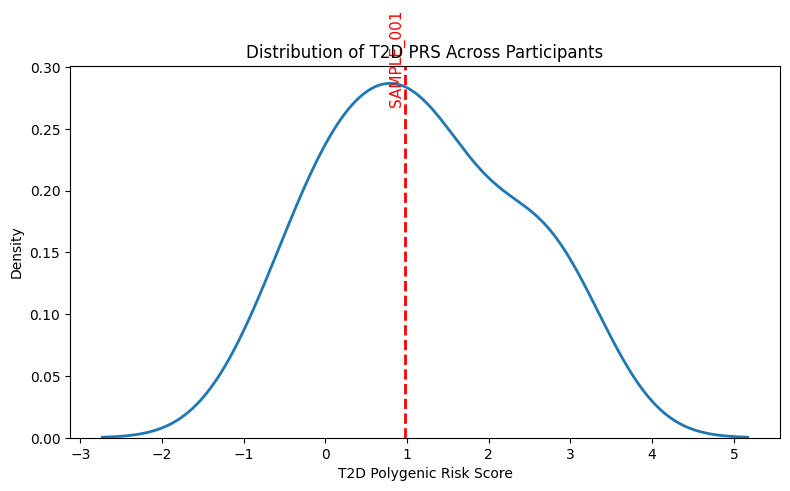

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Name of column for the total T2D PRS
TOTAL_COL = "t2dp-suzuki24-ma_total"

# Choose an individual (by IID)
iid = df["IID"].iloc[0]   # or: iid = "Anto"
person_score = df.loc[df["IID"] == iid, TOTAL_COL].iloc[0]

plt.figure(figsize=(8,5))

# KDE plot of the distribution
sns.kdeplot(df[TOTAL_COL], linewidth=2)

# Vertical line for the chosen individual
plt.axvline(person_score, color="red", linestyle="--", linewidth=2)
plt.text(
    person_score,
    plt.ylim()[1]*0.9,
    f"{iid}",
    rotation=90,
    color="red",
    fontsize=11,
    ha="right"
)

plt.xlabel("T2D Polygenic Risk Score")
plt.ylabel("Density")
plt.title("Distribution of T2D PRS Across Participants")
plt.tight_layout()
